### 2.10 Анализ удержания произвольных когорт. Функция subplot()

Вы научились рассчитывать и отображать на графиках удержание пользователей. Однако все проанализированные данные имеют одну особенность: пользователи разбиваются по когортам по дате первого посещения. Так бывает далеко не всегда.

Участников когорты может объединять определённое событие — посещение сайта, регистрация, скачивание мобильного приложения; период времени, в который это событие произошло; а также любые дополнительные признаки: профессия, география, возраст, пол, поведенческие особенности.

Написанная нами функция `get_retention()` сможет рассчитать удержание в большинстве таких случаев. Достаточно её немного изменить.

Ещё раз взглянем на код функции `get_retention()`:


In [56]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

In [58]:
import pandas as pd

# Загрузим датафреймы result_raw, profiles и sessions, 
# получившиеся в предыдущем уроке, чтобы не повторять вычисления

result_raw = pd.read_csv('/datasets/result_backup.csv')
profiles = pd.read_csv('/datasets/profiles_backup.csv')
sessions = pd.read_csv('/datasets/sessions_backup.csv')

In [44]:
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

In [45]:
result_raw['first_ts'] = pd.to_datetime(result_raw['first_ts'])
result_raw['month'] = pd.to_datetime(result_raw['month'])
result_raw['session_start'] = pd.to_datetime(result_raw['session_start'])

В блоке с расчётом удержания построение сводной таблицы, группировка и объединение данных выполняются по столбцу `dt`, который хранит дату первого посещения пользователей.

In [46]:
result_grouped = result_raw.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)  # сводная таблица с количеством пользователей на каждый лайфтайм

cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)  # таблица с размерами когорт

result_grouped = cohort_sizes.merge(
    result_grouped, on='dt', how='left'
).fillna(0)  # объединение таблиц

Если заменить прописанный в этом блоке столбец `dt` на передаваемый список столбцов, функция станет универсальной и сможет строить таблицы удержания для любых когорт.

Добавим в объявление функции `get_retention()` аргумент `dimensions` и заменим на него `dt` в части с расчётом удержания.


In [47]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],  # новый параметр dimensions
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    # новый вариант с dimensions
    result_grouped = result_raw.pivot_table(
        index=dimensions,  # заменили dt
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)  # заменили dt
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  # заменили dt
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

Проверим работоспособность функции, передав ей в качестве параметра `dimensions` дату привлечения пользователей магазина «Читать не вредно» из столбца `dt`. Для наглядности построим хитмэп. Если всё верно, результат будет тем же, что и раньше.

Горизонт и момент анализа данных — 6 дней и 13 мая соответственно.

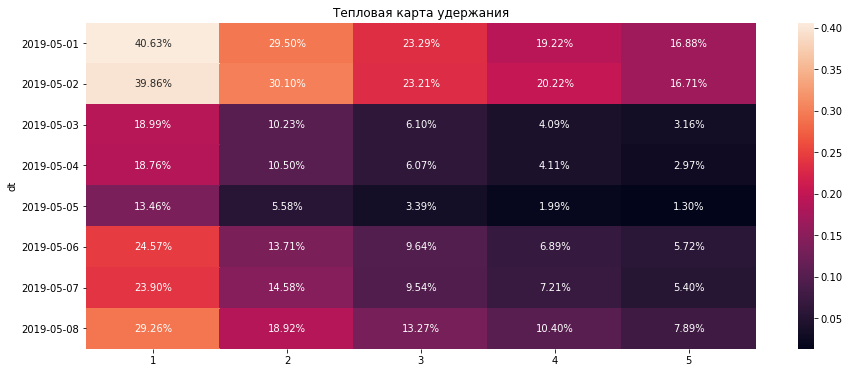

In [48]:
# импортируем нужные модули
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, dimensions=['dt']
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

Результат один в один. Функция работает корректно.

Теперь передадим параметру `dimensions` какое-нибудь другое значение. Например, столбец `payer` с данными о том, совершал ли пользователь покупку. Результат отобразим в виде кривых удержания.


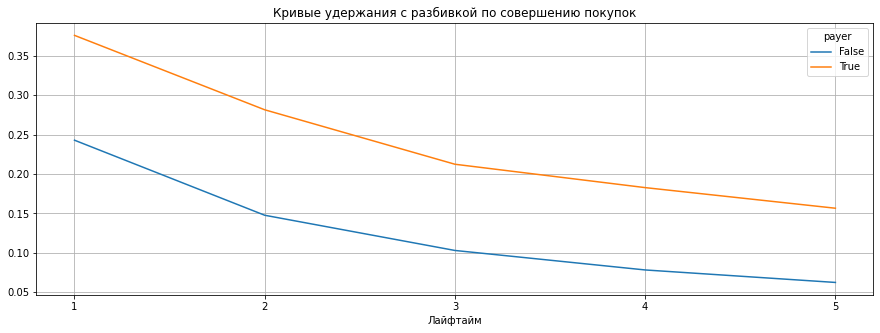

In [49]:
# рассчитываем удержание с учётом совершения покупки

retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, dimensions=['payer']
)  # передаём параметру dimensions столбец payer

report = retention.drop(columns=['cohort_size', 0])
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(15, 5))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по совершению покупок')
plt.show()

Удержание платящих значительно выше удержания неплатящих. Так бывает почти всегда, поэтому разбивка пользователей на платящих и неплатящих — стандартная практика.

Чтобы не задавать это разделение всякий раз, сделаем признак совершения покупки предзаданным значением `dimensions` в теле функции `get_retention()`.


In [50]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    # новый вариант с dimensions
    result_grouped = result_raw.pivot_table(
        index=dimensions,  # заменили dt
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)  # заменили dt
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  # заменили dt
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

Вызовем изменённую функцию и снова построим тепловую карту с разбивкой по датам.

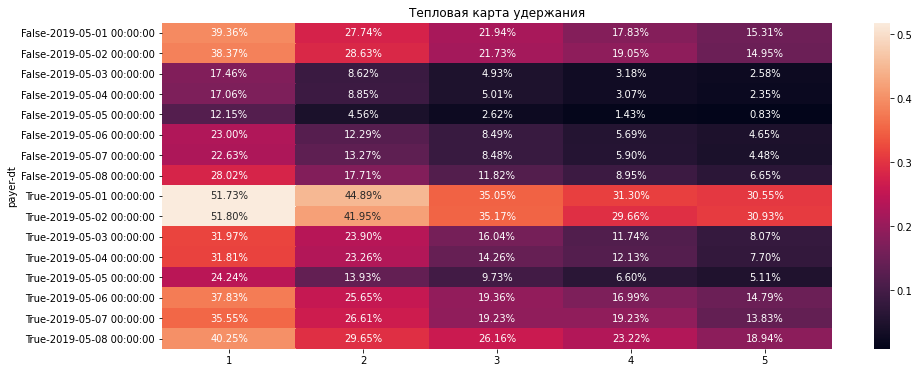

In [51]:
retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, dimensions=['dt']
)  # передаём параметру dimensions столбец dt

plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

Теперь каждой строке таблицы удержания соответствуют два параметра: дата и признак совершения покупки. График и подписи заметно разрослись.

Разделим график надвое: построим по тепловой карте для каждой группы пользователей — платящих и неплатящих. Для этого вызовем функцию `figure()` из модуля `pyplot` библиотеки `matplotlib` и напишем цикл `for`.


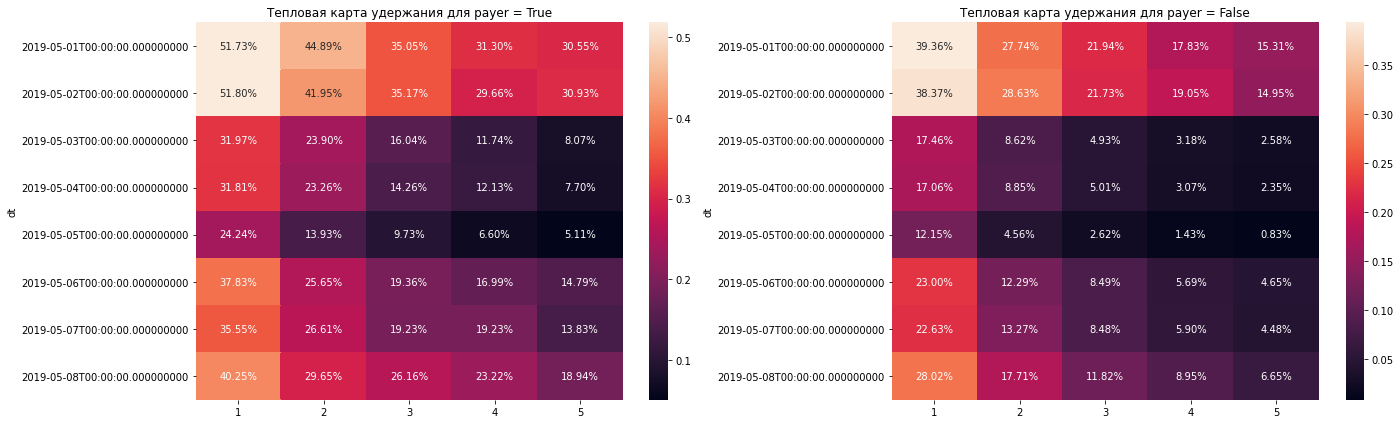

In [52]:
plt.figure(figsize=(20, 6)) # задаём размер сетки для графиков

for i, payer in enumerate(profiles['payer'].unique()):
    sns.heatmap(
        retention.query('payer == @payer')
        # удаляем payer из индексов, чтобы не загромождать графики
        .droplevel('payer')
        # исключаем размеры когорт и удержание первого дня
        .drop(columns=['cohort_size', 0]),
        # добавляем подписи значений
        annot=True,
        # переводим значения в проценты
        fmt='.2%',
        # строим каждый график в своей ячейке
        ax=plt.subplot(1, 2, i + 1),
    )
    # задаём названия графиков с учётом значения payer
    plt.title('Тепловая карта удержания для payer = {}'.format(payer))

plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
plt.show()

Получаем два хитмэпа. Один для пользователей со значением `True` в столбце `payer`, то есть платящих, другой — для неплатящих, со значением `payer = False`.

##### Разберём код

Прежде чем строить графики, нужно создать для них пространство. Параметр `figsize` функции `figure()` позволяет определить размер фигуры, или сетки для графиков. Графиков будет два, поэтому ширину задаём побольше.

```python
plt.figure(figsize=(20, 6))
```

Затем пишем цикл. Функция `enumerate()` принимает список элементов, присваивает им порядковые номера и возвращает пары «номер-элемент». Если передать `enumerate()` список уникальных значений столбца `payer`, она вернёт всего две пары: `(0, True)` и `(1, False)`. Номер элемента сохраним в переменной `i`, а сам элемент — в `payer`.

```python
for i, payer in enumerate(profiles['payer'].unique()):
```

Для каждой пары строим по хитмэпу. В теле цикла вызываем метод `heatmap()` и передаём ему таблицу удержания `retention`. Чтобы на разные графики попали разные данные, на каждой итерации цикла фильтруем датафрейм `retention` методом `query()`: так методу `heatmap()` будут передаваться только те строки `retention`, в которых значения столбца `payer` соответствуют значению переменной `payer` — то есть сначала `0`, а потом `1`.

```python
sns.heatmap(
    retention.query('payer == @payer')
```

Далее удаляем всё лишнее. После фильтрации методом `query()` в индексах датафрейма `retention` оказалось сразу два признака: `payer` и `dt`. Значение `payer` можно вынести в заголовок графика, поэтому удаляем этот уровень методом `droplevel()`. Также удалим размеры когорт и удержание первого дня методом `drop()`, добавим на график подписи в параметре `annot` и переведём значения в проценты с точностью до двух знаков после запятой, задав параметр `fmt`.

```python
    .droplevel('payer')
    # исключаем размеры когорт и удержание первого дня
    .drop(columns=['cohort_size', 0]),
    # добавляем подписи значений
    annot=True,
    # переводим значения в проценты
    fmt='.2%',
```

Теперь самая важная часть — необходимо вписать каждый график в свою «ячейку». Для этого вызовем функцию `subplot()`, которая определяет место графика в воображаемой таблице графиков. Вот её позиционные аргументы:

- количество строк в таблице графиков,
- количество столбцов в таблице графиков,
- порядковый номер ячейки.

Например, первые два аргумента — `3` и `4`: `subplot(3, 4, ...)`. Тогда в таблице графиков будет 3 строки и 4 столбца.


Каждая ячейка этой таблицы имеет свой порядковый номер: от 1 до 12. Этот номер и определяет положение графика. Если функции `subplot()` в качестве третьего позиционного аргумента передать `3` — `plt.subplot(3, 4, 3)`, — график появится в третьей ячейке первой строки.


В программе для построения двух хитмэпов мы передали функции `subplot()` аргументы `1`, `2` и `i + 1`: в таблице графиков одна строка и два столбца. 

```python
        ax=plt.subplot(1, 2, i + 1)
```

Переменная `i` принимает значения `0` и `1`, а нумерация ячеек в таблице графиков начинается с единицы, поэтому значение `i` увеличиваем на один. Так первый график окажется в первой ячейке, а второй — во второй.

##### Больше графиков

Проанализируем удержание с разбивкой когорт не по дате, а по другому параметру — устройству, с которого пользователи впервые зашли на сайт. Эта информация сохранена в столбце `device` — добавим его в параметр `dimensions`. Горизонт и момент анализа данных остаются прежними. Вызовем функцию `get_retention()` и построим хитмэп.


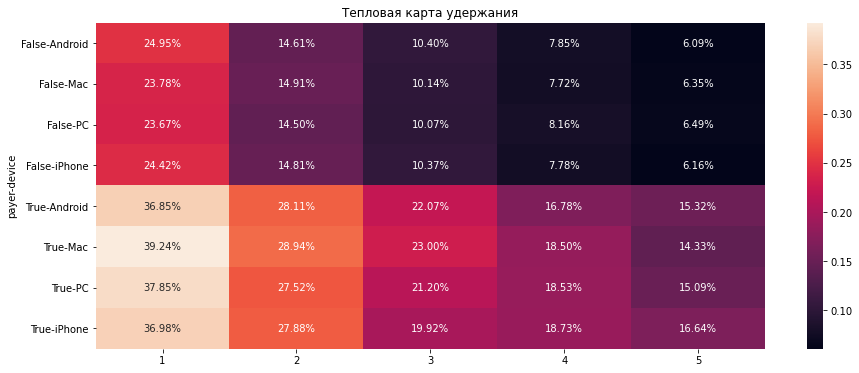

In [53]:
# строим тепловую карту с разбивкой по устройствам

retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6, dimensions=['device']
)

plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

Разделение пользователей на платящих и неплатящих уже «зашито» в функцию `get_retention()`, поэтому в индексах два признака: совершение покупки — `True` или `False` — и устройство первого перехода на сайт — `Android`, `Mac`, `PC` или `iPhone`.

Оттенки значений каждого столбца очень близки, и лидера выявить трудно. Возможно, кривые удержания будут информативнее. Разделим график надвое по признаку `payer` и вызовем метод `plot()` к транспонированной таблице удержания.


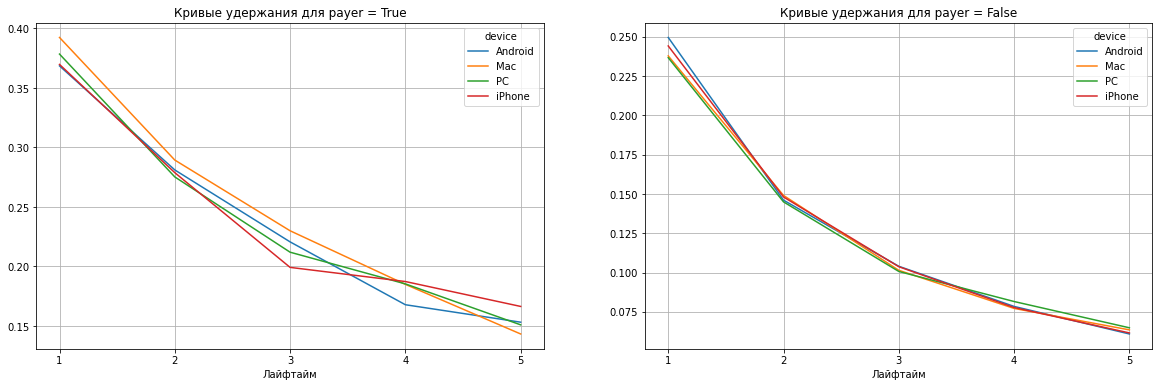

In [54]:
# строим кривые удержания

plt.figure(figsize=(20, 6))  # задаём размер сетки

# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,  # добавляем сетку
        # отметки на оси X — названия колонок
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

На графике удержания платящих пользователей выделяется оранжевая линия: в течение первых четырёх лайфтаймов удержание пользователей Mac немного выше. На пятый день «жизни» в лидеры по удержанию выходят пользователи iPhone. Согласно второму графику, удержание неплатящих примерно одинаково для всех платформ.

In [55]:
report

1         2         3         4         5
payer device                                                   
False Android  0.249548  0.146056  0.103978  0.078453  0.060926
      Mac      0.237832  0.149053  0.101431  0.077178  0.063532
      PC       0.236694  0.144959  0.100695  0.081573  0.064857
      iPhone   0.244154  0.148062  0.103721  0.077752  0.061591
True  Android  0.368545  0.281103  0.220657  0.167840  0.153169
      Mac      0.392429  0.289411  0.229995  0.184954  0.143268
      PC       0.378468  0.275250  0.211987  0.185350  0.150943
      iPhone   0.369767  0.278811  0.199225  0.187339  0.166408